# Top 10 Stations for MTA Advertising
###### METIS Data Science and Machine Learning Bootcamp 2022 by Krystian Krystkowiak
###### project/month(1) focus: EXPLORATORY DATA ANALYSIS

ABSTRACT
- Utilized MTA turnstile data to identify optimal locations for Christmas advertising campaign in New York.

### Cleaning and preparing the MTA turnstile data for analysis

In [49]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import sqlite3
import sqlalchemy as db
from sqlalchemy import create_engine

In [50]:
#Importing turnstile data from SQL database with SQLAlchemy

engine = create_engine("sqlite:///mta_data.db")
turnstiles_df = pd.read_sql('SELECT * FROM mta_data;', engine)

turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,00:00:00,REGULAR,7714568,2706545
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,04:00:00,REGULAR,7714583,2706554
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,08:00:00,REGULAR,7714590,2706575
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,12:00:00,REGULAR,7714641,2706648
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/21/2022,16:00:00,REGULAR,7714728,2706690


In [51]:
#Cleaning column names

turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [52]:
#Extracting and reformat the DATE and TIME columns to datetime format

turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")
turnstiles_df["DATE"] = pd.to_datetime(turnstiles_df.DATE, format="%m/%d/%Y")

In [53]:
#Verifying that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique for ENTRIES

unique_entries = (turnstiles_df
.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES", ascending=False))

unique_entries.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
11609960,S101,R070,00-00-02,ST. GEORGE,2021-09-27 08:00:00,2
9602928,R285,R308,00-00-00,MT EDEN AV,2019-11-06 07:00:00,2
9602930,R285,R308,00-00-00,MT EDEN AV,2019-11-06 15:00:00,2
9602931,R285,R308,00-00-00,MT EDEN AV,2019-11-06 19:00:00,2
9602932,R285,R308,00-00-00,MT EDEN AV,2019-11-06 23:00:00,2


In [54]:
#Checking specific case to understand the problem

mask = ((turnstiles_df["C/A"] == "S101") &
(turnstiles_df["UNIT"] == "R070") &
(turnstiles_df["SCP"] == "00-00-02") &
(turnstiles_df["STATION"] == "ST. GEORGE") &
(turnstiles_df["DATE_TIME"].dt.date == dt.datetime(2021, 9, 3).date()))

turnstiles_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
8200149,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,00:00:00,REGULAR,1396478,324,2021-09-03 00:00:00
8200150,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,00:00:00,RECOVR AUD,1213528,140,2021-09-03 00:00:00
8200151,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,04:00:00,REGULAR,1396480,324,2021-09-03 04:00:00
8200152,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,08:00:00,REGULAR,1396536,324,2021-09-03 08:00:00
8200153,S101,R070,00-00-02,ST. GEORGE,1,SRT,2021-09-03,08:00:00,RECOVR AUD,1213576,140,2021-09-03 08:00:00


In [55]:
#Dropping duplicate entries

turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [56]:
#Checking again to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is now unique for ENTRIES

(turnstiles_df
.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31 00:00:00,1
7802070,R141,R031,00-00-00,34 ST-PENN STA,2022-01-21 15:00:00,1
7802050,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 07:00:00,1
7802051,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 11:00:00,1
7802052,R141,R031,00-00-00,34 ST-PENN STA,2022-01-18 15:00:00,1


In [57]:
#Dropping the EXITS and DESC columns

turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [58]:
#Finding daily ENTRIES as a base for calculations, grab the highest reading of the day

turnstiles_daily = turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.max()
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31,7183842
1,A002,R051,02-00-00,59 ST,2019-09-01,7184559
2,A002,R051,02-00-00,59 ST,2019-09-02,7185132
3,A002,R051,02-00-00,59 ST,2019-09-03,7186355
4,A002,R051,02-00-00,59 ST,2019-09-04,7187672


In [59]:
#Creating columns with previous date and entries number. As entries records are cumulative, those columns will be used to establish daily entry anjustment.

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
.groupby(["C/A", "UNIT", "SCP", "STATION"])
.apply(lambda grp: grp[["DATE", "ENTRIES"]].shift(1)))

turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31,7183842,NaT,NaN
1,A002,R051,02-00-00,59 ST,2019-09-01,7184559,2019-08-31,7183842.0
2,A002,R051,02-00-00,59 ST,2019-09-02,7185132,2019-09-01,7184559.0
3,A002,R051,02-00-00,59 ST,2019-09-03,7186355,2019-09-02,7185132.0
4,A002,R051,02-00-00,59 ST,2019-09-04,7187672,2019-09-03,7186355.0


In [60]:
#Drop rows with NaN values in the PREV_DATE column

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [61]:
#Defining a function to calculate daily entries, fixing negative counts, and ones over 50000

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
#        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

#Apply function to turnstiles_daily and creating new column with daily entries
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=50000)


In [62]:
#Dropping "ENTRIES", "PREV_DATE" and "PREV_ENTRIES" columns. "DAILY_ENTRIES" is the only column that will be used for further analysis.

turnstiles_daily.drop(columns=["ENTRIES", "PREV_DATE", "PREV_ENTRIES"], inplace=True)

turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,2019-09-01,717.0
2,A002,R051,02-00-00,59 ST,2019-09-02,573.0
3,A002,R051,02-00-00,59 ST,2019-09-03,1223.0
4,A002,R051,02-00-00,59 ST,2019-09-04,1317.0
5,A002,R051,02-00-00,59 ST,2019-09-05,1353.0


### Data analisys and visualisations

In [63]:
#Generating dataframes of daily traffic at each station for the specified time periods

station_daily_2019_sept_dec = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2019, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2020, 1, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_2021_sept_dec = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2021, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 1, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_2022_jan_may = turnstiles_daily[(turnstiles_daily["DATE"].dt.date >= dt.datetime(2022, 1, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 6, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()

station_daily_2022_jan_may.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,2022-01-01,3013.0
1,1 AV,2022-01-02,3662.0
2,1 AV,2022-01-03,6782.0
3,1 AV,2022-01-04,7074.0
4,1 AV,2022-01-05,7361.0


In [64]:
#Identyfying 10 stations with highest number of entries in specified periods

def get_top_10_stations(period_df):
    return period_df.groupby('STATION').sum()\
        .sort_values('DAILY_ENTRIES', ascending=False)\
        .reset_index().head(10)

top_10_stations_2019_sept_dec = get_top_10_stations(station_daily_2019_sept_dec)
top_10_stations_2021_sept_dec = get_top_10_stations(station_daily_2021_sept_dec)
top_10_stations_2022_jan_may = get_top_10_stations(station_daily_2022_jan_may)

top_10_stations_2022_jan_may

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,6761005.0
1,GRD CNTRL-42 ST,5311000.0
2,34 ST-HERALD SQ,5150211.0
3,23 ST,4833367.0
4,42 ST-PORT AUTH,4770424.0
5,86 ST,4741748.0
6,14 ST-UNION SQ,4272072.0
7,125 ST,4188586.0
8,TIMES SQ-42 ST,4172535.0
9,FULTON ST,3982469.0


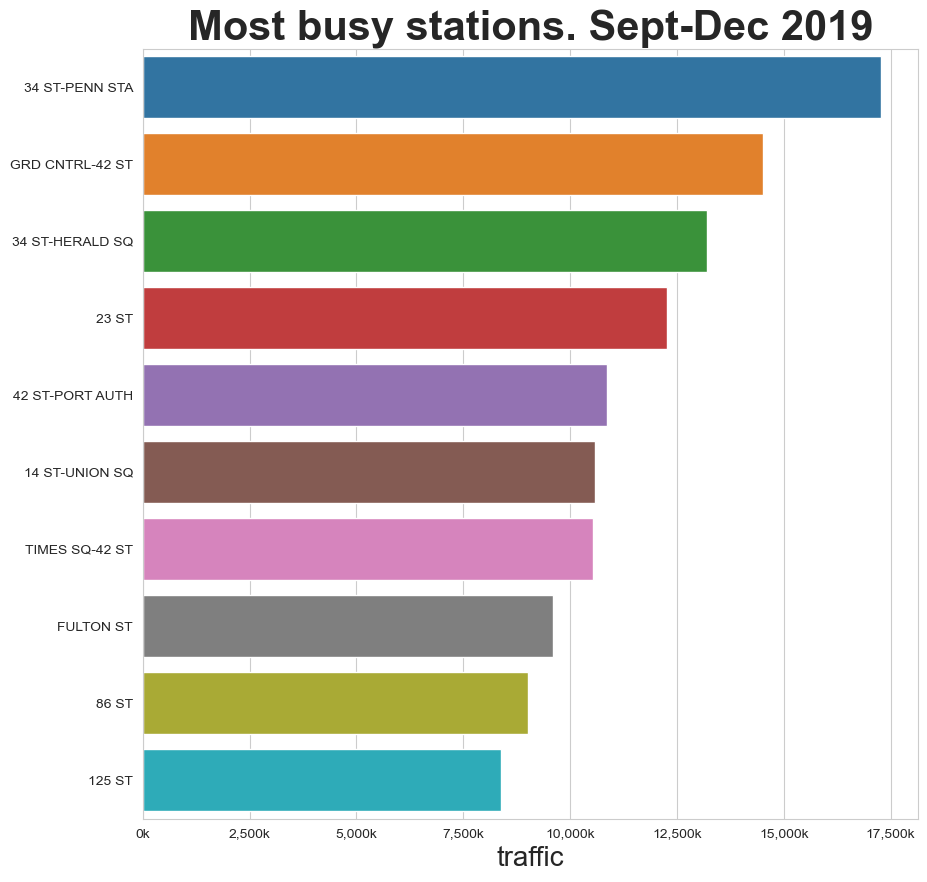

In [87]:
#Creating horizontal bar plots of 10 stations with highest number of entries in specified periods

import matplotlib.ticker as ticker

plt.figure(figsize = [10,10])
sns.set_style("whitegrid")

sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', data = top_10_stations_2019_sept_dec)

plt.title('Most busy stations. Sept-Dec 2019', weight='bold', fontsize = 30)
plt.ylabel('')
plt.xlabel('traffic', fontsize = 20)

# Setting x-axis tick labels to be in thousands
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x/1000)))

plt.savefig('most_busy_stations_Sept_Dec_2019', transparent=True, bbox_inches = 'tight')


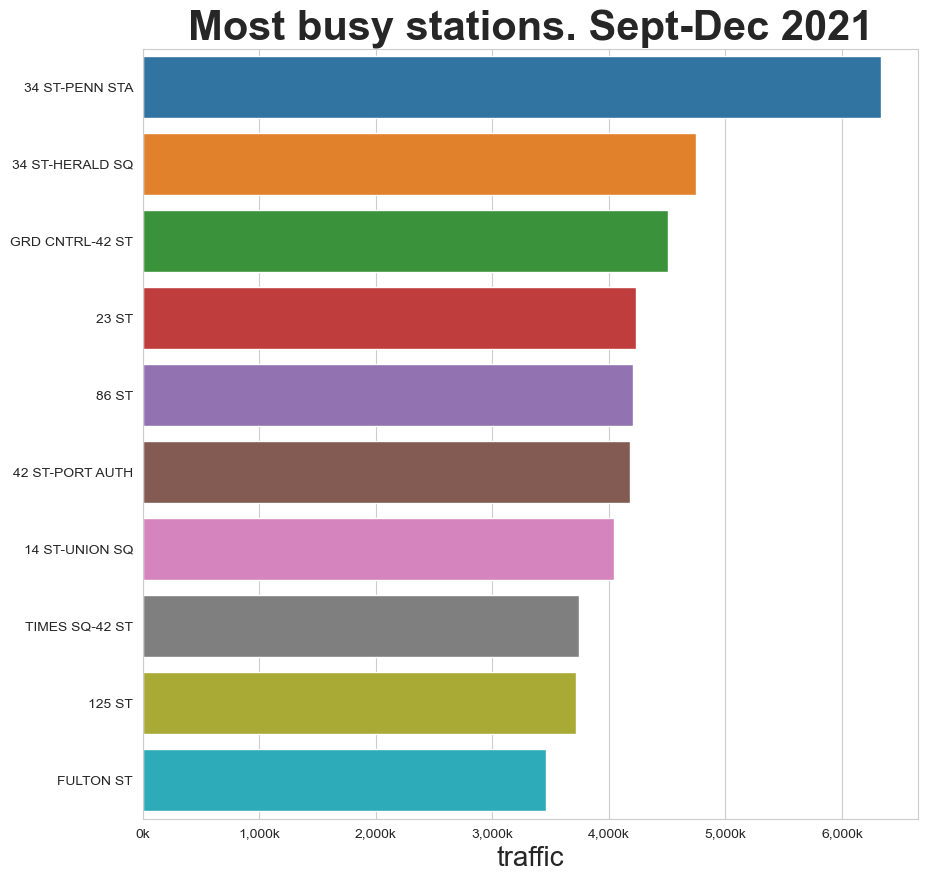

In [88]:
#Creating horizontal bar plots of 10 stations with highest number of entries in specified periods

import matplotlib.ticker as ticker

plt.figure(figsize = [10,10])
sns.set_style("whitegrid")

sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', data = top_10_stations_2021_sept_dec)

plt.title('Most busy stations. Sept-Dec 2021', weight='bold', fontsize = 30)
plt.ylabel('')
plt.xlabel('traffic', fontsize = 20)

# Setting x-axis tick labels to be in thousands
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x/1000)))

plt.savefig('most_busy_stations_Sept_Dec_2021', transparent=True, bbox_inches = 'tight')


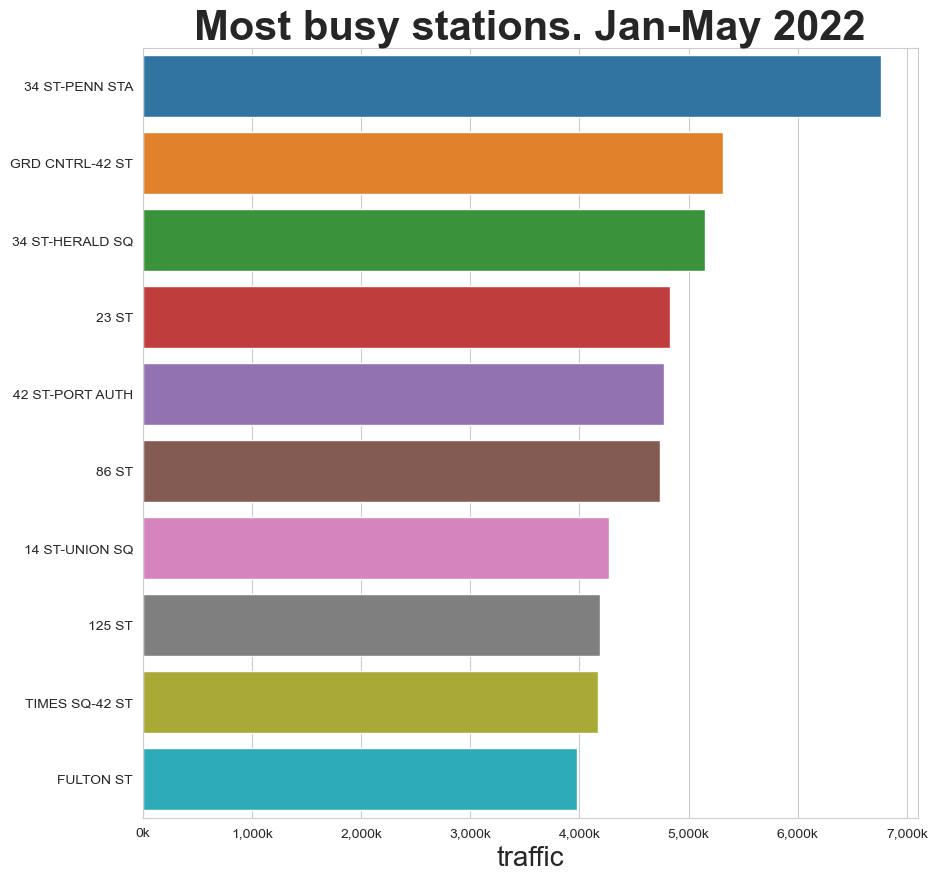

In [89]:
#Creating horizontal bar plots of 10 stations with highest number of entries in specified periods

plt.figure(figsize = [10,10])
sns.set_style("whitegrid")

sns.barplot(x = 'DAILY_ENTRIES', y = 'STATION', data = top_10_stations_2022_jan_may)

plt.title('Most busy stations. Jan-May 2022', weight='bold', fontsize = 30)
plt.ylabel('')
plt.xlabel('traffic', fontsize = 20)

# Setting x-axis tick labels to be in thousands
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x/1000)))

plt.savefig('most_busy_stations_Jan_May_2022', transparent=True, bbox_inches = 'tight')


In [79]:
#As FULTON ST is at the bottom of the 2022 list, taking closer look and trying to identyfy trend

fulton_st_daily = turnstiles_daily[(turnstiles_daily["STATION"] == "FULTON ST") & (turnstiles_daily["DATE"].dt.date >= dt.datetime(2021, 9, 1).date()) & (turnstiles_daily["DATE"].dt.date < dt.datetime(2022, 6, 1).date())].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
fulton_st_monthly = fulton_st_daily.groupby(fulton_st_daily.DATE.dt.month)['DAILY_ENTRIES'].sum().reset_index()

fulton_st_monthly

,DATE,DAILY_ENTRIES
0,1,661305.0
1,2,727034.0
2,3,908098.0
3,4,875768.0
4,5,810264.0
5,9,820322.0
6,10,897380.0
7,11,876731.0
8,12,866141.0


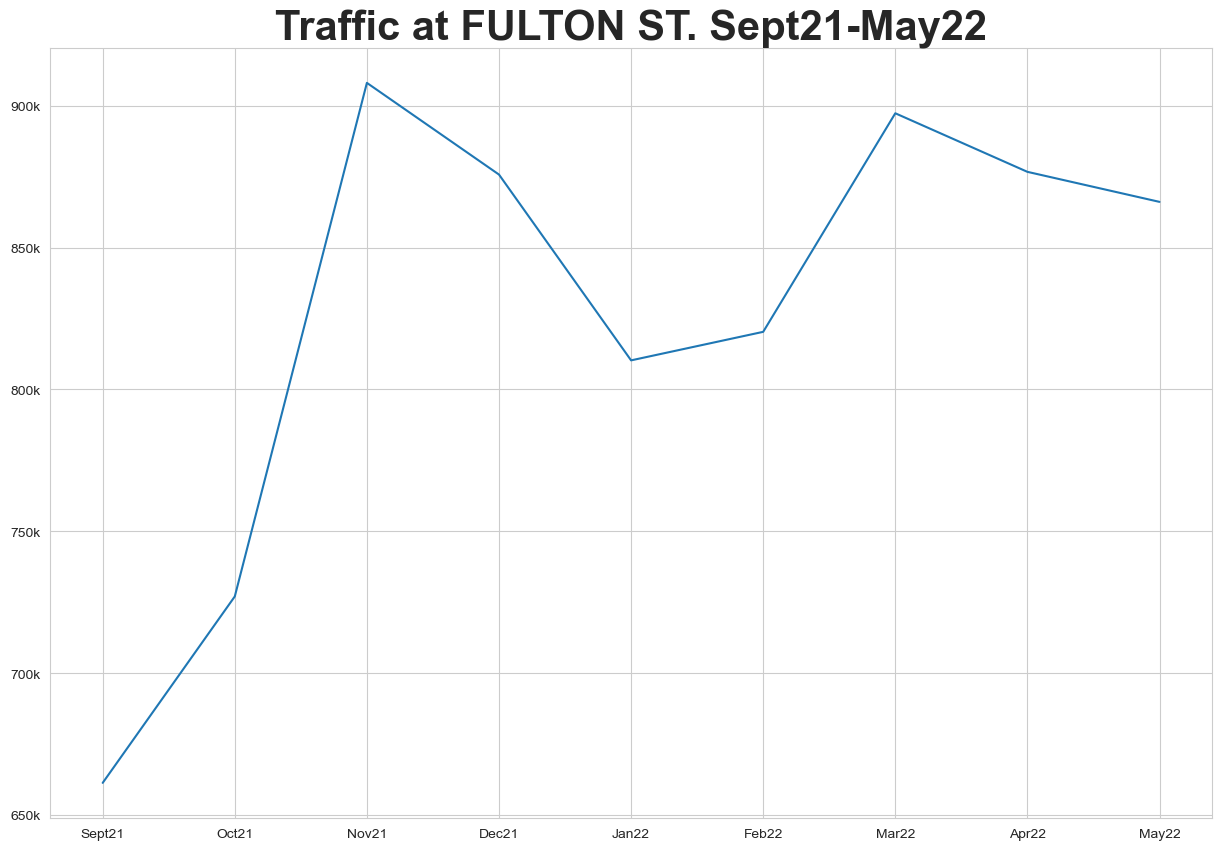

In [96]:
#Creating plot of FULTON ST traffic during Sept21-May22. As it is last one at top 10 list, checking how stable is the traffic

plt.figure(figsize=(15,10))
plt.plot(fulton_st_monthly.index, fulton_st_monthly['DAILY_ENTRIES'])
plt.ylabel('')
plt.xlabel('')
plt.xticks([ 0, 1, 2, 3, 4, 5, 6, 7, 8], ['Sept21', 'Oct21', 'Nov21', 'Dec21', 'Jan22', 'Feb22', 'Mar22', 'Apr22', 'May22'])
plt.title('Traffic at FULTON ST. Sept21-May22', weight='bold', fontsize = 30)

# Set y-axis tick labels to be in thousands
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x/1000)))

plt.savefig('traffic_at_FULTON_ST_Sept21-May22', transparent=True, bbox_inches = 'tight')


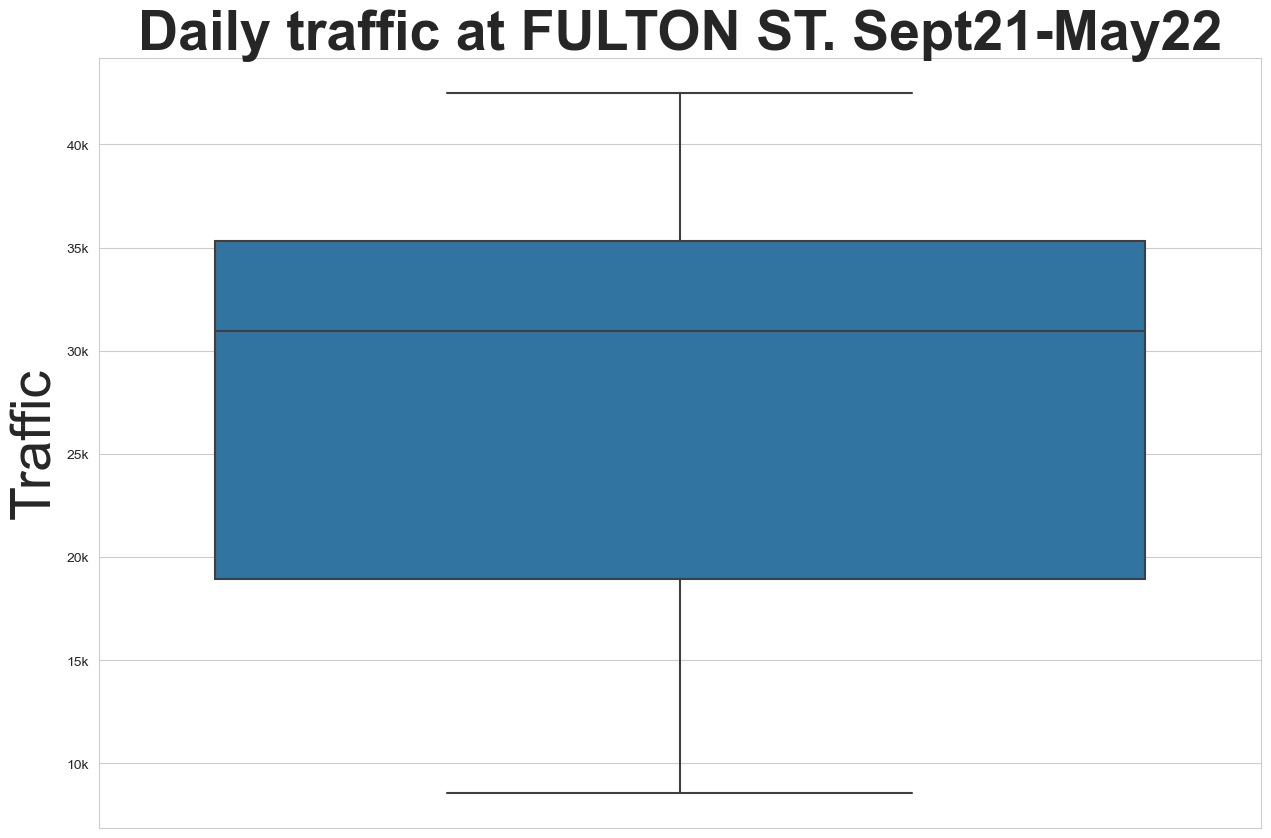

In [102]:
#Creating box plot of FULTON ST traffic during Sept21-May22. As it is last one at top 10 list, checking how stable is the traffic

plt.figure(figsize = [15,10])
sns.set_style("whitegrid")

# Create box plot using seaborn
sns.boxplot(data = fulton_st_daily['DAILY_ENTRIES'])

# Add title and y-axis label
plt.title('Daily traffic at FULTON ST. Sept21-May22', weight='bold', fontsize = 40)
plt.ylabel('Traffic', fontsize = 40)
plt.xticks([])

# Setting y-axis tick labels to be in thousands
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}k'.format(x/1000)))

# Save figure
plt.savefig('daily_traffic_at_FULTON_ST_Sept21-May22', transparent=True, bbox_inches = 'tight')
